In [1]:
#!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
#!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
#!pip install torch-geometric


In [2]:
#!pip install git+https://github.com/rusty1s/pyg_autoscale.git


In [1]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import torch_geometric
from torch_sparse import SparseTensor
from torch_geometric.data import Data
from torch_geometric_autoscale import metis, permute, SubgraphLoader
import numpy as np
from matplotlib import pyplot as plt
from torch_geometric.nn import SAGEConv
from torch_geometric_autoscale.models.base import ScalableGNN
from torch_geometric_autoscale import metis, permute, SubgraphLoader
from torch.nn import ModuleList
from datetime import datetime
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import to_undirected
import json
from uuid import UUID
from base64 import b64decode as b64d
import networkx as nx

In [2]:
import random
import itertools
def dataprocess(data): #удаление ребер для валидации 
        #splitting data to train and test
        train_edge_index = []
        val_edge_index = []
        indices_to_delete_for_val  = np.random.choice(list(range(len(data.edge_index[0]))), int(len(data.edge_index[0])*0.2),replace=False)
        l=0
        for i,x in enumerate(list(zip(*data.edge_index.tolist()))):
            l+=1
            if i in indices_to_delete_for_val: 
                val_edge_index.append(x)
            else: 
                train_edge_index.append(x)
                
        val_edge_index = torch.tensor(np.array(list(zip(*val_edge_index))))
        train_edge_index = torch.tensor(np.array(list(zip(*train_edge_index))), dtype = torch.long)
        
        s = set(itertools.combinations(range(len(data.x)), 2))
        
        s_of_edges = set()
        
        for pair in (data.edge_index.t().tolist()):
            s_of_edges.add(tuple(pair))
        s_of_non_edges = s - s_of_edges
        
        #append negative samples to test set
        non_edges=[]
        for pair in list(s_of_non_edges):
            non_edges.append(list(pair))
        non_edges_val=torch.tensor(random.choices(non_edges, k = len(val_edge_index[0]))).t()
        y_true_val = [1]*len(val_edge_index[0])
        val_edge_index=torch.cat((val_edge_index,non_edges_val),1)
        y_true_val += [0]*len(non_edges_val[0])
        data.edge_index = train_edge_index
        
        return data,non_edges_val,val_edge_index,y_true_val #data уже обрезанная по ребрам
    


In [3]:
def data_load(): #загрузить и обработать данные
    with open('assets (9)','r', encoding="utf-8") as f:
        assets = json.load(f)

    with open('asset_embeddings (1)','r') as f:
        embeddings = json.load(f)

    to_uuid = lambda x: str(UUID(b64d(x, altchars=None, validate=False).hex()))
    
    rels = []
    
    for asset in assets:
        if asset['cited_articles']:
            source = to_uuid(asset['asset_id']['$binary'])
            for tt in  asset['cited_articles']:
                target = to_uuid(tt['$binary'])
                rels.append(tuple([source,target]))
    emb_map = {}
   
    for emb in embeddings:
        emb_map[to_uuid(emb['asset_id']['$binary'])] = emb['embedding']

    rels = [x for x in rels if x[0] in emb_map and x[1] in emb_map]
    mapping_old_to_new={}
    mapping_new_to_old = {}
    
    for id_new,id_old in enumerate(emb_map):
            mapping_old_to_new[id_old] = id_new
            mapping_new_to_old[id_new] = id_old
            
    x = []
    for id_new,id_old in enumerate(emb_map):
        if id_new!=len(emb_map)-1:
            x.append(emb_map[id_old]) 
        
    edges = list(map(lambda edge: [mapping_old_to_new[edge[0]], mapping_old_to_new[edge[1]]], rels)) 

    edges_to_graph = list(filter(lambda edge: (edge[0] != len(emb_map)-1) and ((edge[1] != len(emb_map)-1)) , edges)) 
    edges_to_vertex = list(filter(lambda edge: (edge[0] == len(emb_map)-1) or ((edge[1] == len(emb_map)-1)) , edges)) 
    G = nx.Graph()
    G.add_edges_from(edges_to_graph) #чтоб граф точно был направленным, в Graph ребра в одну сторону выписываются, хотя и считаются ненаправленными
    
    data_init = Data(x=torch.tensor(x),edge_index = torch.tensor(list(G.edges)).t() ) #тут все ребра
    return  data_init,mapping_new_to_old,mapping_old_to_new,edges_to_vertex, emb_map

In [4]:
def di_to_undirected(data):
    data.edge_index=to_undirected(data.edge_index)
    data.adj_t=SparseTensor(row=data.edge_index[0],col=data.edge_index[1],sparse_sizes=(len(data.x),len(data.x)))
    #SparseTensor.from_edge_index(data.edge_index)
    return data

In [5]:
data_init, mapping_new_to_old,mapping_old_to_new,edges_to_vertex,embs=data_load() #data_init - это самый изначальный граф, маппинги вершин
data,non_edges_val,val_edge_index,y_true_val = dataprocess(data_init) #data - здесь уже без части ребер, для валидации надо
data = di_to_undirected(data)#добавление ребер в обратную сторону
data_init = di_to_undirected(data_init)#добавление ребер в обратную сторону


In [7]:
l=[]
for i in range(768):
    l.append((random.random()))
l

[0.05296272353579912,
 0.9175472138192473,
 0.8811217302271236,
 0.2920485259320418,
 0.10029090411773556,
 0.3676452328179284,
 0.8947273944380368,
 0.5764944820296138,
 0.7326820953580538,
 0.042754954421536207,
 0.3706365740548918,
 0.6710640699294622,
 0.2652880363984014,
 0.9769814198410949,
 0.7853958298319698,
 0.9484088995882706,
 0.6842910280364134,
 0.7817298027711445,
 0.7309043207813105,
 0.21625588423551645,
 0.40192949319020876,
 0.8090304001925255,
 0.6704646355686849,
 0.65978472052646,
 0.21293798506251294,
 0.13561407291207084,
 0.5463965096491107,
 0.12263575082207556,
 0.07798522033507171,
 0.9114051680911228,
 0.7906265011528475,
 0.24613787839846002,
 0.23476188571274414,
 0.9445137939824617,
 0.014288409442186345,
 0.23364235633147634,
 0.877874043483939,
 0.1941345116521237,
 0.5640604222155272,
 0.48304610429646344,
 0.63054154603766,
 0.33917760870318747,
 0.8701075392083494,
 0.8400646215865778,
 0.015752271807421447,
 0.7717771883685767,
 0.11517887062171883

In [8]:
vertex = (mapping_new_to_old[1282],embs[mapping_new_to_old[1282]])
neighbors = [(mapping_new_to_old[587],embs[mapping_new_to_old[587]]),(mapping_new_to_old[589],embs[mapping_new_to_old[589]]), ('any',l)]

In [9]:
neighbors_of_neighbors=[]

for neig in [587,589]:
        for neig_of_neig in (data_init.edge_index[0]==torch.tensor(neig)).nonzero()[0]:
            neighbors_of_neighbors.append((mapping_new_to_old[int(data_init.edge_index[1][neig_of_neig])],embs[mapping_new_to_old[int(data_init.edge_index[1][neig_of_neig])]]))

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  after removing the cwd from sys.path.


In [10]:
neighbors_of_neighbors=[]

for neig in [587,589]:
        for neig_of_neig in (data_init.edge_index[1]==torch.tensor(neig)).nonzero()[0]:
            neighbors_of_neighbors.append((mapping_new_to_old[int(data_init.edge_index[0][neig_of_neig])],embs[mapping_new_to_old[int(data_init.edge_index[0][neig_of_neig])]]))

In [12]:
perm, ptr = metis(data.adj_t, num_parts=40, log=True)
data_train = permute(data, perm, log=True)
loader = SubgraphLoader(data_train, ptr, batch_size=10, shuffle=True)

Computing METIS partitioning with 40 parts... Done! [0.01s]
Permuting data... Done! [0.01s]


In [13]:
class Scalable(ScalableGNN):
    def __init__(self, data, num_nodes, in_channels, hidden_channels,
                 out_channels, num_layers,mapping_new_to_old,mapping_old_to_new):
        # * pool_size determines the number of pinned CPU buffers
        # * buffer_size determines the size of pinned CPU buffers,
        #   i.e. the maximum number of out-of-mini-batch nodes

        super().__init__(num_nodes, hidden_channels, num_layers,
                         pool_size=2, buffer_size=5000)
        self.out_channels=out_channels
        self.convs = ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))
        self.mapping_new_to_old = mapping_new_to_old
        self.data = data
        self.mapping_old_to_new=mapping_old_to_new
    def forward(self, x, adj_t, *args):
        for i, (conv, history) in enumerate(zip(self.convs, self.histories)):
            if i == len(self.convs)-1:
                x = conv(x, adj_t)
            else:
                x = conv(x, adj_t).relu_()
            x = self.push_and_pull(history, x, *args)
            
        return x # self.convs[-1](x, adj_t)
    def inference(self,vertex,neighbors,neighbors_of_neighbors,*args):
         #предполагаю что среди neighbors_of_neighbors- нет новых
            #нет проверки на то, пришли ко мне одинаковые вершины или разные
        model.eval()
        #обработка новых вершин
        new_embs=1
        if vertex[0] not in self.mapping_old_to_new:  
                self.mapping_old_to_new[vertex[0]] = len(self.mapping_old_to_new)
                self.mapping_new_to_old[self.mapping_old_to_new[vertex[0]]] = vertex[0]
                self.data.x = torch.cat((data.x,torch.tensor(vertex[1]).reshape(1,-1)))
        for vid in list(zip(*neighbors))[0]:
            if vid not in self.mapping_old_to_new:  
                self.mapping_old_to_new[vid] = len(self.mapping_old_to_new)
                self.mapping_new_to_old[self.mapping_old_to_new[vid]] = vid
                self.data.x = torch.cat((data.x,torch.tensor(vertex[1]).reshape(1,-1)))
                new_embs+=1
        
        new_edges = []
        new_ver = self.mapping_old_to_new[vertex[0]]
        for neighbor in neighbors:
            new_edges.append([new_ver,self.mapping_old_to_new[neighbor[0]]])
            new_edges.append([self.mapping_old_to_new[neighbor[0]],new_ver])
        self.data.edge_index =  torch.cat([data.edge_index,torch.tensor(new_edges).t()],-1)
        
        #обновляем сам граф
        x = self.data.x
        self.data.adj_t = SparseTensor.from_edge_index(data.edge_index)#SparseTensor(row=self.data.edge_index[0],col=self.data.edge_index[1],sparse_sizes=(len(self.data.x),len(self.data.x)))
        #adj_t = self.data.adj_t
        
        #делаем батч только нужных нам вершин и соседей
        c1=list(zip(*neighbors))[0]
        c2=list(zip(*neighbors))[1]
        c1+=(list(zip(*neighbors_of_neighbors))[0])
        c2+=(list(zip(*neighbors_of_neighbors))[1])
        all_neighbors=list(zip(c1,c2)) #(old index, input embedding)
        
        remap_new_to_new2 = {}
        remap_new2_to_new = {}
        remap_new_to_new2[0] = self.mapping_old_to_new[vertex[0]]
        remap_new_to_new2[self.mapping_old_to_new[vertex[0]]] = 0
        for new_index, neigbor in enumerate(c1):
            remap_new_to_new2[self.mapping_old_to_new[neigbor]] = new_index+1
            remap_new2_to_new[new_index+1] = self.mapping_old_to_new[neigbor]
        
        #находим ребра
        
        first = ((self.data.edge_index[0]==self.mapping_old_to_new[vertex[0]]).nonzero(as_tuple=True)[0]).tolist()
        second =  ((self.data.edge_index[1]==self.mapping_old_to_new[vertex[0]]).nonzero(as_tuple=True)[0]).tolist()
        
        for neighbor in c1: 
            first+=(((self.data.edge_index[0]==self.mapping_old_to_new[neighbor]).nonzero(as_tuple=True)[0]).tolist())
            second+=(((self.data.edge_index[1]==self.mapping_old_to_new[neighbor]).nonzero(as_tuple=True)[0]).tolist())
        
        
        edge_index_indices = list(set(first).intersection(set(second)))
        edge_index_1 = self.data.edge_index[0][torch.tensor(edge_index_indices)]
        edge_index_1=list(map( lambda x: remap_new_to_new2[x], edge_index_1.tolist()))
        edge_index_2 = self.data.edge_index[1][torch.tensor(edge_index_indices)]
        edge_index_2=list(map( lambda x: remap_new_to_new2[x], edge_index_2.tolist()))
        batch_edge_index = torch.stack((torch.tensor(edge_index_1),torch.tensor(edge_index_2))) 
        
        #делаем из него adj_t#перепроверить возможно не правильно так делать 
        adj_t=SparseTensor.from_edge_index(batch_edge_index)
        #собираем х!!!! 
        x=[vertex[1]]
        x+=c2
        
        x=torch.tensor(x)
        
        #сам inference
        for i, conv in enumerate(self.convs):
            if i == len(self.convs)-1:
                x = conv(x, adj_t)
            else:
                x = conv(x, adj_t).relu_()
        
        out=[]
        for i in range(new_embs,0,-1):
            new_index = len(self.mapping_old_to_new)-i
            out.append((self.mapping_new_to_old[new_index],x[remap_new_to_new2[new_index]]))
        return out 
    
    def loss(self,out, PosNegSamples):
        (pos_rw,neg_rw) = PosNegSamples
            # Negative loss
        start, rest = neg_rw[:, 0].type(torch.LongTensor), neg_rw[:, 1:].type(torch.LongTensor).contiguous()
        h_start =out[start].view(neg_rw.size(0), 1,self.out_channels)
        
        h_rest =  out[rest.view(-1)].view(neg_rw.size(0), -1,self.out_channels)
        dot = (h_start * h_rest).sum(dim=-1).view(-1)
        neg_loss = -torch.log(torch.sigmoid((-1)*dot)).mean()
            # Positive loss.
        start, rest = pos_rw[:, 0].type(torch.LongTensor), pos_rw[:, 1].type(torch.LongTensor).contiguous()
        h_start = out[start].view(pos_rw.size(0), 1,self.out_channels)

        h_rest = out[rest.view(-1)].view(pos_rw.size(0), -1,self.out_channels)
        dot = ((h_start * h_rest).sum(dim=-1)).view(-1)
        pos_loss = -(torch.log(torch.sigmoid(dot))).mean() 
        return pos_loss + neg_loss
        


In [14]:
def neg_samples(edge_index,ind,num_negative_samples): #возвращает негативные примеры
    d=datetime.now()
    neg_samples=torch.Tensor(size=(len(ind),num_negative_samples+1))
    neg_samples.t()[0] = ind
    for i in ind:
        d=datetime.now()
        neig=(edge_index[1][(edge_index[0]==i).nonzero(as_tuple=True)[0]])
        neg_neigbors=ind[~ind.unsqueeze(1).eq(neig).any(1)] #difference between all indices and neighbors
        neg_neigbors=(neg_neigbors[(neg_neigbors!=i).nonzero(as_tuple=True)[0]])
        #probs = torch.zeros(max(neg_neigbors)+1)
        d=datetime.now()
        #probs[neg_neigbors]=1
        d = datetime.now()
        neg_samples[i][1:]=torch.tensor(np.random.choice(neg_neigbors,num_negative_samples))
        
    
    return neg_samples

def edge_index(batch,size): #выбираются ребра только для батча и только для вершин внутри батча
    adj=batch.adj_t
    t=(adj.to_torch_sparse_coo_tensor()).coalesce()
    ind = torch.tensor(range(size))
    edge_index = t.indices()
    first=((edge_index[0]<len(ind)).nonzero(as_tuple=True)[0])
    second=((edge_index[1]<len(ind)).nonzero(as_tuple=True)[0])
    new_indices=(torch.tensor(np.intersect1d(first,second)))
    edge_index1 =  edge_index[0][new_indices]
    edge_index2 = edge_index[1][new_indices]
    return (torch.stack([edge_index1, edge_index2], dim=0)),ind

In [15]:
def train(model,loader,num_negative_smples):
    total_loss = 0
    model.train()
    for batch,*args in loader:
        optimizer.zero_grad()
        out = model(batch.x[:args[0]], batch.adj_t,*args)
        e_index,ind=edge_index(batch,args[0])
        #print('edge index construct',datetime.now()-d)
        pos = e_index.t()
        
        neg = neg_samples(e_index,ind,num_negative_smples)
        samples = (pos,neg)
        loss = model.loss(out, samples)
        losses.append(loss)
        loss.backward()
        optimizer.step() 
        total_loss+=loss
    return total_loss/len(loader)
def test(y_true,model,data,val_edge_index):
    model.eval()
    out = model(data.x, data.adj_t)

    y_pred = []
    for x in list(zip(*val_edge_index)):
        y_pred.append(float(torch.sigmoid(torch.dot(out[x[0]],out[x[1]]))))#print(torch.sigmoid(torch.dot(out[x[0]],out[x[1]])))
    
    return roc_auc_score(y_true,torch.tensor(y_pred).detach().numpy()) 
 

In [16]:
len(data_init.x)

1282

In [17]:
old_index=mapping_new_to_old[len(embs)-1]
mapping_new_to_old.pop(len(embs)-1)
mapping_old_to_new.pop(old_index)

1282

In [18]:
len(mapping_old_to_new)

1282

0 tensor(1.4276, grad_fn=<DivBackward0>) 0.7404883654122378
1 tensor(1.3401, grad_fn=<DivBackward0>) 0.7824992818155703
2 tensor(1.2623, grad_fn=<DivBackward0>) 0.8060787130135019
3 tensor(1.2003, grad_fn=<DivBackward0>) 0.8167193335248493
4 tensor(1.1799, grad_fn=<DivBackward0>) 0.8213272048261994
5 tensor(1.1530, grad_fn=<DivBackward0>) 0.8295547256535478
6 tensor(1.1773, grad_fn=<DivBackward0>) 0.8415053145647804
7 tensor(1.1307, grad_fn=<DivBackward0>) 0.8508014938236139
8 tensor(1.1218, grad_fn=<DivBackward0>) 0.8593507612754955
9 tensor(1.1020, grad_fn=<DivBackward0>) 0.8638437230680839


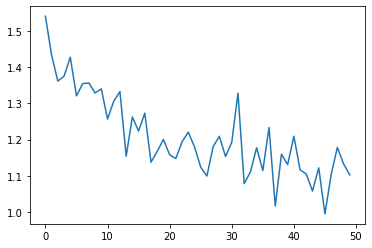

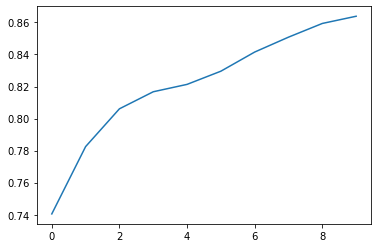

0:00:00.390705


In [19]:
d = datetime.now()
model = Scalable(data_init, num_nodes=len(data.x), in_channels=len(data.x[0]), hidden_channels=128,out_channels=128, num_layers=2, mapping_new_to_old=mapping_new_to_old,mapping_old_to_new=mapping_old_to_new)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay = 1e-5)
num_negative_smples=4
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
losses=[]
scores=[]

for epoch in range(10):
        d=datetime.now()
        loss=train(model,loader,num_negative_smples)
        losses.append(float(loss))
        scheduler.step(loss)
        score=test(y_true_val,model,data,val_edge_index)
        scores.append(score)
        print(epoch,loss,score)
plt.plot(torch.tensor(losses).tolist())
plt.show()
plt.plot(torch.tensor(scores).tolist())
plt.show()
print(datetime.now()-d)

# Сам инференс

In [20]:
#test
x=model.inference(vertex,neighbors,neighbors_of_neighbors)

# plotting

In [ ]:
G = igraph.Graph.TupleList(rels, weights=False, directed=True)
igraph.summary(G)

In [22]:
x

[('bf2009fb-5859-499d-9fe2-7334bb23ad9d',
  tensor([-3.0107e-02,  9.4633e-02,  4.5891e-02, -6.6886e-02, -8.7278e-02,
           1.3694e-01, -1.4957e-01, -4.3116e-02,  5.9198e-02, -9.7398e-02,
           2.0575e-03,  9.2069e-02, -7.6678e-02,  9.2932e-02, -5.5742e-03,
          -2.4954e-01, -6.8726e-02, -1.3190e-02,  1.8677e-02,  4.8087e-02,
          -1.5204e-01, -9.5113e-02,  3.7323e-02,  7.0868e-02,  1.9982e-02,
           8.9551e-02,  1.0408e-02,  7.5286e-02, -5.1205e-02, -1.3756e-01,
           3.4742e-02, -4.6605e-02,  4.2456e-03,  2.9065e-02, -2.5053e-01,
           6.2558e-04,  1.2581e-01,  8.3188e-02, -8.0341e-02, -6.2990e-02,
          -1.6177e-02, -9.9823e-04, -3.7491e-02, -8.3898e-02,  1.7528e-01,
           4.3861e-02, -2.5226e-01, -1.0818e-02, -3.1307e-02, -2.4857e-02,
           1.6376e-01,  1.3063e-01, -2.1551e-02,  1.7644e-02, -1.6836e-01,
          -1.2791e-02, -4.2412e-03, -2.8947e-02, -9.5810e-03,  2.2692e-03,
          -9.3626e-02,  1.4776e-01, -2.0646e-02,  9.8707e-

In [21]:
len(model.mapping_old_to_new)

1284

In [ ]:
samples

In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import math
# plot tree
init_notebook_mode()
def plot(G, annotations=False):

    lay = G.layout_fruchterman_reingold(grid="nogrid", niter=1000)
    nr_vertices = len(G.vs)
    position = {k: lay[k] for k in range(nr_vertices)}
    Y = [lay[k][1] for k in range(nr_vertices)]
    M = max(Y)
    labels = [x['name'] for x in G.vs()]
    es = igraph.EdgeSeq(G) # sequence of edges
    E = [e.tuple for e in G.es] # list of edges

    L = len(position)
    Xn = [position[k][0] for k in range(L)]
    Yn = [2*M-position[k][1] for k in range(L)]
    Xe = []
    Ye = []
    for edge in E:
        Xe+=[position[edge[0]][0],position[edge[1]][0], None]
        Ye+=[2*M-position[edge[0]][1],2*M-position[edge[1]][1], None] 


    #Create Plotly Traces

    lines = go.Scatter(x=Xe,
                       y=Ye,
                       mode='lines',
                       line=dict(color='rgb(210,210,210)', width=1),
                       hoverinfo='none'
                       )
    dots = go.Scatter(x=Xn,
                      y=Yn,
                      mode='markers',
                      name='',
                      marker=dict(  colorbar=dict(
                                        title="Modularity"
                                    ),
                                    colorscale="Viridis",
                                    
                                  
                                    line=dict(color='rgb(50,50,50)', width=1)
                                    ),
                      
                      hoverinfo='text',
                      opacity=0.8
                      )

    # Create Text Inside the Circle via Annotations

    def make_annotations(pos, text, font_size=10, 
                         font_color='rgb(0,0,0)'):
        L=len(pos)
        if len(text)!=L:
            raise ValueError('The lists pos and text must have the same len')
        annotations = go.Annotations()
        for k in range(L):
            annotations.append(
                go.Annotation(
                    text=labels[k], # or replace labels with a different list 
                                    # for the text within the circle  
                    x=pos[k][0], y=2*M-position[k][1],
                    xref='x1', yref='y1',
                    font=dict(color=font_color, size=font_size),
                    showarrow=False)
            )
        return annotations  

    # Add Axis Specifications and Create the Layout

    axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
                zeroline=False,
                showgrid=False,
                showticklabels=False,
                )
    ann = []
    if annotations:
        ann = make_annotations(position, labels)
    layout = dict(#title= 'Tree with Reingold-Tilford Layout',  
                  height=900,
                  annotations=ann,
                  font=dict(size=12),
                  showlegend=False,
                  xaxis=go.XAxis(axis),
                  yaxis=go.YAxis(axis),          
                  margin=dict(l=40, r=40, b=85, t=100),
                  hovermode='closest',
                  plot_bgcolor='rgb(248,248,248)'          
                  )

    # Plot

    data=go.Data([lines, dots])
    fig=dict(data=data, layout=layout)
    #fig['layout'].update(annotations=make_annotations(position, labels))
    iplot(fig, filename='Tree-Reingold-Tilf')
    # use py.plot instead of py.iplot if you're not using a Jupyter notebook

In [ ]:
plot(G)

In [ ]:
def train(model,data,optimizer,epoch):
        model.train()   
        total_loss = 0
        optimizer.zero_grad()
        out = model.forward(data,data.adj_t)
        samples = Sampler.sample(nodes)
        loss = model.loss(out, samples)
        return loss

# optuna todo 

In [ ]:
def objective(trial):
    
        data,mapping_new_to_old=data_loader()
        print(data)
        perm, ptr = metis(data.adj_t, num_parts=40, log=True)
        data_train = permute(data, perm, log=True)
        loader = SubgraphLoader(data_train, ptr, batch_size=10, shuffle=True)
        len(loader)

        hidden_layer = trial.suggest_categorical("hidden_layer", [32,64,128,256])
        out_layer = trial.suggest_categorical("out_layer", [64,128])
        size = trial.suggest_categorical("size of network, number of convs", [2,3])
        num_negative_samples=trial.suggest_categorical('num neg samples', [1,2,3,4,5,6,7,8,9,10])
        model = Scalable(num_nodes=len(data.x), in_channels=len(data.x[0]), hidden_channels=hidden_layer,out_channels=out_layer, num_layers=size)
        learning_rate= trial.suggest_float("lr",5e-4,1e-2)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  

        for epoch in range(50):
            loss = train(model,loader,num_negative_smples)
        score=test(y_true_val,model,data,val_edge_index)
        
        trial.report(score,epoch)

        return score

In [ ]:
import optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials = 20)

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))